# Recommender systems workbook
This miniproject is realized in the course "Decision Support Systems" at Aarhus University in the Spring semester of 2023 by Alexander Stæhr Johansen, Henrik Tambo Buhl & Liulihan Kuang from team 3.

The purpose of this workbook is to exemplify basic implementations of recommendation systems: a content-based, one using collaborative-filtering and a hybrid of the two.

## Background

In [2]:
# Import libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the movielens Small dataset from local storage
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

## Content-based recommender system

In [3]:
def content_based_recommender(user_id, cosine_sim, df_movies, df_ratings, n=10):
    user_ratings = df_ratings[df_ratings['userId'] == user_id]
    user_ratings = user_ratings[['movieId', 'rating']]

    # Compute the mean rating for the user
    mean_user_rating = user_ratings['rating'].mean()

    # Find the indices of the movies rated by the user
    movie_indices = user_ratings['movieId'].apply(lambda x: df_movies[df_movies['movieId'] == x].index[0])

    # Calculate the cosine similarity scores between the user's movies and all other movies
    sim_scores = cosine_sim[movie_indices].mean(axis=0)

    # Sort the movies based on the similarity scores
    sim_scores = sorted(list(enumerate(sim_scores)), key=lambda x: x[1], reverse=True)

    # Get the top N most similar movies (excluding the movies rated by the user)
    sim_scores = [score for score in sim_scores if score[0] not in movie_indices][:n]
    recommended_movie_indices = [i[0] for i in sim_scores]

    # Calculate the predicted rating for each recommended movie
    predicted_ratings = [mean_user_rating] * n

    # Return the recommended movieIds and their predicted ratings
    recommended_movies = df_movies.iloc[recommended_movie_indices]['movieId'].tolist()
    return pd.DataFrame({'movieId': recommended_movies, 'predicted_rating': predicted_ratings})

### Example usage of content-based recommender system

To exemplify the usage, one can execute the block below.

In [3]:
# Compute the TF-IDF vectors for movie genres
#vectorizer = TfidfVectorizer()
#movie_genres = movies['genres'].fillna('').str.lower().str.replace('|', ' ')
#tfidf_matrix = vectorizer.fit_transform(movie_genres)

# Compute the cosine similarity between movies based on their genre vectors
#cosine_sim = cosine_similarity(tfidf_matrix)

# Example usage: get the top 5 recommended movies and their predicted ratings for user 1
#content_based_recommendations = content_based_recommender(1, cosine_sim, movies, ratings, n=5)
#print(content_based_recommendations[['movieId', 'predicted_rating']])


   movieId  predicted_rating
0   117646          4.366379
1    55116          4.366379
2     5657          4.366379
3     6990          4.366379
4   164226          4.366379


## Collaborative-filtering-based recommender system

In [4]:
def collaborative_filtering_recommender(user_id, cosine_sim, user_item_matrix, movies, n=10):
    # Convert the user_id to the corresponding index in user_item_matrix
    idx = user_item_matrix.index.get_loc(user_id)
    
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    similar_users_indices = [i[0] for i in sim_scores]

    # Convert the similar users' indices back to user IDs
    similar_users = user_item_matrix.iloc[similar_users_indices].index.tolist()

    movies_rated = user_item_matrix.loc[similar_users].sum().sort_values(ascending=False)
    movies_rated = movies_rated.index.values.tolist()

    movies_seen = user_item_matrix.loc[user_id]
    movies_seen = movies_seen[movies_seen > 0].index.values.tolist()
    movies_to_recommend = [m for m in movies_rated if m not in movies_seen][:n]

    recommended_movie_ids = movies.loc[movies['movieId'].isin(movies_to_recommend)]['movieId'].tolist()

    # Calculate the average rating for the recommended movies
    recommended_movie_ratings = user_item_matrix.loc[similar_users][recommended_movie_ids].mean().tolist()

    # Return the recommended movie IDs and their predicted ratings
    return pd.DataFrame({'movieId': recommended_movie_ids, 'predicted_rating': recommended_movie_ratings})

### Example usage of the collaborative-filtering-based recommender system

To exemplify the usage, one can execute the block below.

In [5]:
# Pivot the ratings dataframe to create a user-item matrix
#user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')
#user_item_matrix = user_item_matrix.fillna(0)

# Compute the cosine similarity between users based on their ratings
#cosine_sim = cosine_similarity(user_item_matrix)

# Example usage: get the top 5 recommended movies and their predicted ratings for user 1
#collaborative_filtering_recommendations = collaborative_filtering_recommender(1, cosine_sim, user_item_matrix, movies, n=5)
#print(collaborative_filtering_recommendations[['movieId', 'predicted_rating']])

   movieId  predicted_rating
0      541               4.0
1      589               4.0
2     1036               4.0
3     1200               4.8
4     1610               4.3


## Content-based and collaborative-filtering-based recommender system (hybrid)

In [5]:
def hybrid_recommender(user_id, cosine_sim_content, cosine_sim_cf, user_item_matrix, movies, ratings, n=10, alpha=0.5, num_individual_recommendations=100):
    # Get the top recommended movies and their predicted ratings from content-based and collaborative filtering recommenders
    content_based_recommendations = content_based_recommender(user_id, cosine_sim_content, movies, ratings, n=num_individual_recommendations)
    collaborative_filtering_recommendations = collaborative_filtering_recommender(user_id, cosine_sim_cf, user_item_matrix, movies, n=num_individual_recommendations)

    # Merge the two recommendation sets and compute the hybrid score
    combined_recommendations = content_based_recommendations.merge(collaborative_filtering_recommendations, on='movieId', how='inner')
    combined_recommendations['hybrid_score'] = alpha * combined_recommendations['predicted_rating_x'] + (1 - alpha) * combined_recommendations['predicted_rating_y']

    # Sort the recommendations based on the hybrid score and return the top N recommended movies
    combined_recommendations = combined_recommendations.sort_values(by='hybrid_score', ascending=False).head(n)
    return combined_recommendations[['movieId', 'hybrid_score']].rename(columns={'hybrid_score': 'predicted_rating'})

### Example usage of the hybrid recommender system

To exemplify the usage, one can execute the block below.

In [7]:
# Set the parameters for the hybrid recommender
#n = 100  # number of recommendations to generate
#alpha = 0.5  # weight parameter for combining the content-based and collaborative filtering recommendations
#num_individual_recommendations = 100  # number of individual recommendations to generate from each model

# Compute the necessary similarity matrices and input matrices
#vectorizer = TfidfVectorizer()
#movie_genres = movies['genres'].fillna('').str.lower().str.replace('|', ' ')
#tfidf_matrix = vectorizer.fit_transform(movie_genres)

# Compute the cosine similarity between movies based on their genre vectors (for content-based filtering)
#cosine_sim_content = cosine_similarity(tfidf_matrix)

# Compute the user-item matrix using pivoting
#user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')
#user_item_matrix = user_item_matrix.fillna(0)
#cosine_sim_cf = cosine_similarity(user_item_matrix)
#user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

# Generate the hybrid recommendations for the target user
#hybrid_recommendations = hybrid_recommender(1, cosine_sim_content, cosine_sim_cf, user_item_matrix, movies, ratings, n=n, alpha=alpha, num_individual_recommendations=num_individual_recommendations)

# Print the top recommended movies and their predicted ratings
#print(hybrid_recommendations[['movieId', 'predicted_rating']])

   movieId  predicted_rating
1     6539          4.144301
2     2683          3.941962
0      380          3.901940


## Model evaluation

In [6]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
ratings_train, ratings_test = train_test_split(ratings, test_size=0.2, random_state=42)

# Prepare the user-item matrix for collaborative filtering
user_item_matrix_train = ratings_train.pivot(index='userId', columns='movieId', values='rating')
user_item_matrix_train = user_item_matrix_train.fillna(0)

# Compute the cosine similarity between users based on their ratings (for collaborative filtering)
cosine_sim_collab_train = cosine_similarity(user_item_matrix_train)

# Compute the TF-IDF vectors for movie genres (for content-based filtering)
vectorizer = TfidfVectorizer()
movie_genres = movies['genres'].fillna('').str.lower().str.replace('|', ' ')
tfidf_matrix = vectorizer.fit_transform(movie_genres)

# Compute the cosine similarity between movies based on their genre vectors (for content-based filtering)
cosine_sim_content_train = cosine_similarity(tfidf_matrix)

# Define the evaluation metrics
def evaluate_recommendations(test_data, recommendations):
    # Filter test_data to keep only the recommended movies
    test_data_filtered = test_data[test_data['movieId'].isin(recommendations['movieId'])]

    # If there's no intersection between recommended movies and test data, return None
    if test_data_filtered.empty:
        return None

    # Reorder recommendations according to test_data_filtered
    recommendations = recommendations.set_index('movieId').loc[test_data_filtered['movieId']].reset_index()

    y_true = test_data_filtered['rating'].values
    y_pred = recommendations['predicted_rating'].values

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    return {'mae': mae, 'mse': mse, 'rmse': rmse}

# Set the number of recommendations
n_recommendations = 5

In [7]:
# Evaluate the three recommendation models
metrics = {}  # Dictionary to store evaluation metrics for each user
no_user_ids = len(ratings_test['userId'].unique())  # Total number of unique user IDs in test set
itr_counter = 0  # Iteration counter
for user_id in ratings_test['userId'].unique():  # Iterate over all unique user IDs in test set
    itr_counter = itr_counter + 1
    total_steps = no_user_ids
    progress_percentage = (itr_counter + 1) / total_steps * 100
    if (itr_counter + 1) % 30 == 0:  # Print progress update for every 30th user
        print(f'Progress: {progress_percentage:.2f}%')
    user_ratings_test = ratings_test[ratings_test['userId'] == user_id]  # Get test ratings for current user
    
    # Generate recommendations for current user using the three models
    content_based_recommendations = content_based_recommender(user_id, cosine_sim_content_train, movies, ratings_train, n=n_recommendations)
    collaborative_filtering_recommendations = collaborative_filtering_recommender(user_id, cosine_sim_collab_train, user_item_matrix_train, movies, n=n_recommendations)
    hybrid_recommendations = hybrid_recommender(user_id, cosine_sim_content_train, cosine_sim_collab_train, user_item_matrix_train, movies, ratings_train, n=n_recommendations)

    # Evaluate the quality of the recommendations using the test set ratings
    metrics[user_id] = {
        'content_based': evaluate_recommendations(user_ratings_test, content_based_recommendations),
        'collaborative_filtering': evaluate_recommendations(user_ratings_test, collaborative_filtering_recommendations),
        'hybrid': evaluate_recommendations(user_ratings_test, hybrid_recommendations)
    }

# Calculate the average performance metrics for each model
avg_metrics = {}  # Dictionary to store average performance metrics for each model
for model in ['content_based', 'collaborative_filtering', 'hybrid']:  # iterate over the three models
    # Calculate the average MAE, MSE, and RMSE for the current model using only the users for which there are valid evaluation metrics
    mae = np.mean([metrics[user_id][model]['mae'] for user_id in metrics if metrics[user_id][model] is not None])
    mse = np.mean([metrics[user_id][model]['mse'] for user_id in metrics if metrics[user_id][model] is not None])
    rmse = np.mean([metrics[user_id][model]['rmse'] for user_id in metrics if metrics[user_id][model] is not None])

    # Store the average performance metrics for the current model in the avg_metrics dictionary
    avg_metrics[model] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}


Progress: 4.92%
Progress: 9.84%
Progress: 14.75%
Progress: 19.67%
Progress: 24.59%
Progress: 29.51%
Progress: 34.43%
Progress: 39.34%
Progress: 44.26%
Progress: 49.18%
Progress: 54.10%
Progress: 59.02%
Progress: 63.93%
Progress: 68.85%
Progress: 73.77%
Progress: 78.69%
Progress: 83.61%
Progress: 88.52%
Progress: 93.44%
Progress: 98.36%


### Plotting the results

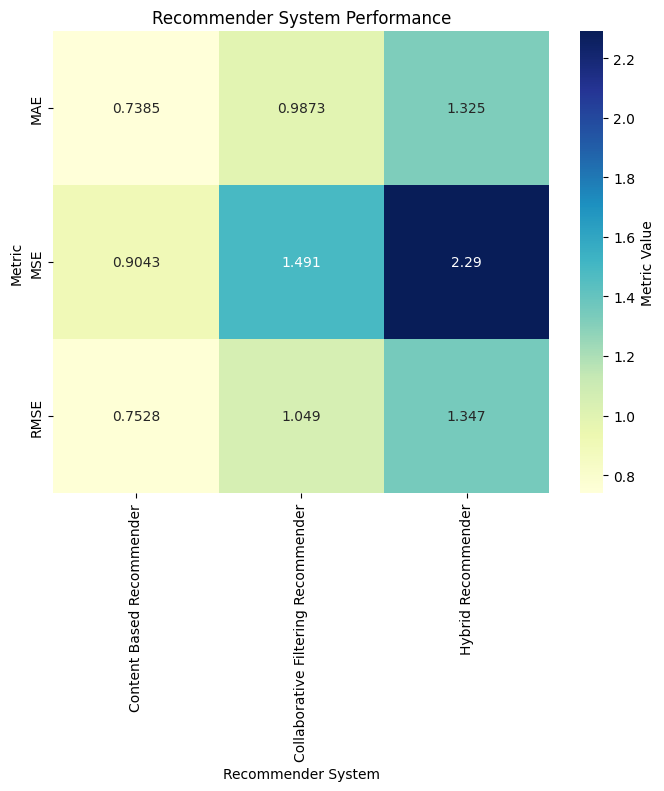

In [8]:
# Import necessary libraries for plotting
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Format metrics such that they can be visualized in a heatmap
formatted_metrics = {}
for model, model_metrics in avg_metrics.items():
    formatted_model_name = ' '.join([word.capitalize() for word in model.split('_')]) + ' Recommender'
    formatted_metrics[formatted_model_name] = model_metrics


# Create dataframe
df = pd.DataFrame(formatted_metrics, index=['MAE', 'MSE', 'RMSE'])

# Plot the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df, cmap='YlGnBu', annot=True, fmt='.4g', cbar_kws={'label': 'Metric Value'})
plt.title('Recommender System Performance')
plt.xlabel('Recommender System')
plt.ylabel('Metric')
plt.show()